In [1]:
import json
import torch
import numpy as np
import torch.nn as nn
from TorchCRF import CRF
import torch.optim as optim
import gensim.downloader as gensim_api

word2vec = gensim_api.load("word2vec-google-news-300")
glove = gensim_api.load("glove-wiki-gigaword-300")
fasttext = gensim_api.load("fasttext-wiki-news-subwords-300")

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Loading Dataset (Json)

In [3]:
with open('../data/NER_train.json','r') as f:
    train_json = json.load(f)
with open('../data/NER_val.json','r') as f:
    val_json = json.load(f)
with open('../data/NER_test.json','r') as f:
    test_json = json.load(f)

In [4]:
import numpy as np
import torch

def get_embeddings(text, embeddings):
    words = text.split()
    embeddings_list = [embeddings[word] if word in embeddings else np.zeros(embeddings.vector_size) for word in words]
    return torch.tensor(embeddings_list, dtype=torch.float32)

# Convert JSON dataset to numerical format
def get_dataset(word_embedding, json_file, label_mapping):
    numerical_dataset = []
    for key, example in json_file.items():
        text_embeddings = get_embeddings(example["text"], word_embedding)
        label_sequence = torch.tensor([label_mapping[label] for label in example["labels"]], dtype=torch.float32)
        numerical_dataset.append((text_embeddings, label_sequence))
    return numerical_dataset

# Updated label mapping
label_mapping = {'B_COURT': 0, 'I_COURT': 1, 'B_PETITIONER': 2, 'I_PETITIONER': 3, 'B_RESPONDENT': 4, 'I_RESPONDENT': 5,
                 'B_JUDGE': 6, 'I_JUDGE': 7, 'B_DATE': 8, 'I_DATE': 9, 'B_ORG': 10, 'I_ORG': 11, 'B_GPE': 12, 'I_GPE': 13,
                 'B_STATUTE': 14, 'I_STATUTE': 15, 'B_PROVISION': 16, 'I_PROVISION': 17, 'B_PRECEDENT': 18, 'I_PRECEDENT': 19,
                 'B_CASE_NUMBER': 20, 'I_CASE_NUMBER': 21, 'B_WITNESS': 22, 'I_WITNESS': 23, 'B_OTHER_PERSON': 24, 'I_OTHER_PERSON': 25,
                 'O': 26}

In [5]:
word2vec_train_embeddings = get_dataset(word_embedding=word2vec, json_file=train_json, label_mapping=label_mapping)
word2vec_val_embeddings = get_dataset(word_embedding=word2vec, json_file=val_json, label_mapping=label_mapping)
word2vec_test_embeddings = get_dataset(word_embedding=word2vec, json_file=test_json, label_mapping=label_mapping)

glove_train_embeddings = get_dataset(word_embedding=glove, json_file=train_json, label_mapping=label_mapping)
glove_val_embeddings = get_dataset(word_embedding=glove, json_file=val_json, label_mapping=label_mapping)
glove_test_embeddings = get_dataset(word_embedding=glove, json_file=test_json, label_mapping=label_mapping)

fasttext_train_embeddings = get_dataset(word_embedding=fasttext, json_file=train_json, label_mapping=label_mapping)
fasttext_val_embeddings = get_dataset(word_embedding=fasttext, json_file=val_json, label_mapping=label_mapping)
fasttext_test_embeddings = get_dataset(word_embedding=fasttext, json_file=test_json, label_mapping=label_mapping)

### Model (BiLSTM)

In [6]:
class BiLSTMCRF(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiLSTMCRF, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, output_size)
        self.crf = CRF(output_size)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state for bidirectional LSTM
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)  # Initialize cell state for bidirectional LSTM
        out, _ = self.lstm(x, (h0, c0))  # Forward propagate bidirectional LSTM
        out = self.fc(out)
        return out

    def neg_log_likelihood(self, x, tags):
        out = self.forward(x)
        return -self.crf(out, tags)

    def decode(self, x):
        out = self.forward(x)
        return self.crf.decode(out)

In [11]:
import torch
import torch.nn as nn
from torchcrf import CRF

class BILSTM_CRF(nn.Module):
    def __init__(self, input_size, hidden_size, num_tags):
        super(BILSTM_CRF, self).__init__()
        self.hidden_size = hidden_size
        self.num_tags = num_tags

        # BILSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(2 * hidden_size, num_tags)

        # CRF layer
        self.crf = CRF(num_tags)

    def forward(self, x):
        ho = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        co = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (ho, co))
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def neg_log_likelihood(self, x, tags):
        emissions = self(x)
        return -self.crf(emissions, tags)

    def forward_crf(self, x):
        emissions = self(x)
        out = self.crf.decode(emissions)
        out = torch.tensor(out)
        out = torch.nn.functional.one_hot(out, num_classes=self.num_tags)
        out = out.permute(1, 0, 2)  # (len, 1, num_tags) to (1, len, num_tags)
        out = out.to(device=x.device)
        return out


ModuleNotFoundError: No module named 'torchcrf'

### Train and loss functions

In [7]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def train_model(model, train_data, val_data, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        predictions_train = []
        true_labels_train = []

        for inputs, labels in train_data:
            optimizer.zero_grad()
            inputs = inputs.unsqueeze(0)
            outputs = model(inputs)
            outputs = outputs.to(torch.float)
            labels = torch.tensor(labels, dtype=torch.long)
            loss = criterion(outputs.view(-1, output_size), labels)
            loss.backward()
            optimizer.step()

            # Keep track of training set predictions and true labels
            _, predicted_train = torch.max(outputs, 2)
            predictions_train.extend(predicted_train.view(-1).cpu().numpy())
            true_labels_train.extend(labels.view(-1).cpu().numpy())

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        predictions = []
        true_labels = []

        with torch.no_grad():
            for inputs, labels in val_data:
                inputs = inputs.unsqueeze(0)
                outputs = model(inputs)
                labels = torch.tensor(labels, dtype=torch.long)
                val_loss += criterion(outputs.view(-1, output_size), labels)
                _, predicted = torch.max(outputs, 2)
                predictions.extend(predicted.view(-1).cpu().numpy())
                true_labels.extend(labels.view(-1).cpu().numpy())

        val_loss /= len(val_data)
        train_losses.append(train_loss / len(train_data))
        val_losses.append(val_loss)

        # Calculate F1 scores
        train_f1 = f1_score(true_labels_train, predictions_train, average='macro')
        val_f1 = f1_score(true_labels, predictions, average='macro')
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}, Train Loss: {train_loss / len(train_data):.4f}, Train F1 Score: {train_f1:.4f}.....')

    # Function to plot loss
    def plot_loss(train_losses, val_losses):
        plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
        plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

    # Function to plot F1 score
    def plot_f1_score(train_f1_scores, val_f1_scores):
        plt.plot(range(1, len(train_f1_scores) + 1), train_f1_scores, label='Training F1 Score')
        plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, label='Validation F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.title('Training and Validation F1 Score')
        plt.legend()
        plt.show()
    plot_loss(train_losses, val_losses)
    plot_f1_score(train_f1_scores, val_f1_scores)


### Testing 

In [8]:
def calculate_f1_score(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(0)
            outputs = model(inputs)
            labels = torch.tensor(labels, dtype=torch.long)
            _, predicted = torch.max(outputs, 2)
            predictions.extend(predicted.view(-1).cpu().numpy())
            true_labels.extend(labels.view(-1).cpu().numpy())
    test_f1 = f1_score(true_labels, predictions, average='macro')
    return test_f1

### Model Training and Evaluation using Word2Vec Embeddings ###

In [ ]:
# Hyperparameters
input_size = 300
hidden_size = 128
output_size = 27  # Number of classes (BIO tags)
learning_rate = 0.001
num_epochs = 10


print(f'\nTraining BiLSTM-CRF model with word2vec embeddings:')
model = BiLSTMCRF(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_model(model, word2vec_train_embeddings, word2vec_val_embeddings, criterion, optimizer, num_epochs)

# Calculate and print the test F1 score
test_f1_score = calculate_f1_score(model, word2vec_test_embeddings)
print(f'BiLSTM Model Testing using word2vec embeddings (Test F1 Score): {test_f1_score:.4f}')

# Save the trained model
torch.save(model.state_dict(), f'BiLSTM_word2vec_model_NER.pth')

### Model Training and Evaluation using Glove Embeddings ###


Training BiLSTM-CRF model with glove embeddings:
Epoch 1/10, Validation Loss: 0.2956, Validation F1 Score: 0.4519, Train Loss: 0.3625, Train F1 Score: 0.3913.....
Epoch 2/10, Validation Loss: 0.2782, Validation F1 Score: 0.5192, Train Loss: 0.2459, Train F1 Score: 0.5560.....
Epoch 3/10, Validation Loss: 0.2779, Validation F1 Score: 0.5451, Train Loss: 0.2050, Train F1 Score: 0.6215.....
Epoch 4/10, Validation Loss: 0.2894, Validation F1 Score: 0.5400, Train Loss: 0.1725, Train F1 Score: 0.6654.....
Epoch 5/10, Validation Loss: 0.3078, Validation F1 Score: 0.5397, Train Loss: 0.1441, Train F1 Score: 0.7103.....
Epoch 6/10, Validation Loss: 0.3033, Validation F1 Score: 0.5543, Train Loss: 0.1204, Train F1 Score: 0.7531.....
Epoch 7/10, Validation Loss: 0.3296, Validation F1 Score: 0.5542, Train Loss: 0.1025, Train F1 Score: 0.7843.....
Epoch 8/10, Validation Loss: 0.3228, Validation F1 Score: 0.5671, Train Loss: 0.0879, Train F1 Score: 0.8127.....
Epoch 9/10, Validation Loss: 0.3442, V

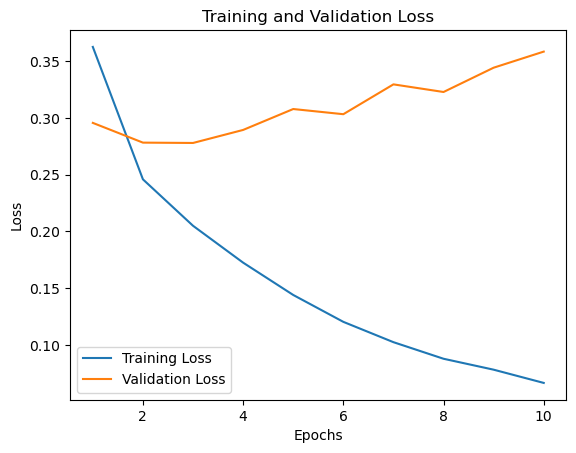

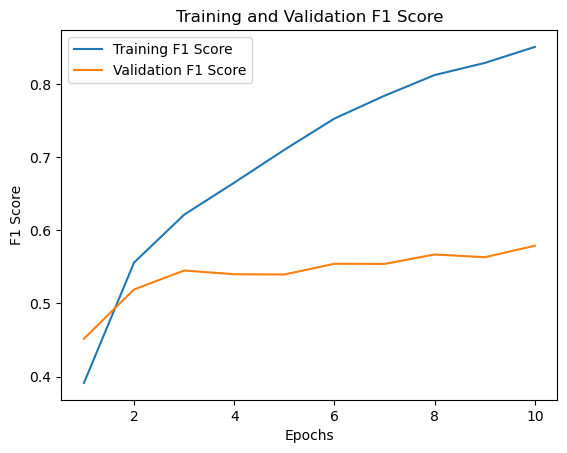

BiLSTM Model Testing using glove embeddings (Test F1 Score): 0.5199


In [ ]:
# Hyperparameters
input_size = 300
hidden_size = 128
output_size = 27 # Number of classes (BIO tags)
learning_rate = 0.001
num_epochs = 10

print(f'\nTraining BiLSTM-CRF model with glove embeddings:')
model = BiLSTMCRF(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_model(model, glove_train_embeddings, glove_val_embeddings, criterion, optimizer, num_epochs)

# Calculate and print the test F1 score
test_f1_score = calculate_f1_score(model, glove_test_embeddings)
print(f'BiLSTM Model Testing using glove embeddings (Test F1 Score): {test_f1_score:.4f}')
torch.save(model.state_dict(), f'bilstm_glove_model_NER.pth')

### Model Training and Evaluation using fasttext Embeddings ###


Training BiLSTM-CRF model with fasttext embeddings:
Epoch 1/10, Validation Loss: 0.2028, Validation F1 Score: 0.5914, Train Loss: 0.3029, Train F1 Score: 0.4733.....
Epoch 2/10, Validation Loss: 0.1776, Validation F1 Score: 0.6596, Train Loss: 0.1607, Train F1 Score: 0.6690.....
Epoch 3/10, Validation Loss: 0.1656, Validation F1 Score: 0.7000, Train Loss: 0.1246, Train F1 Score: 0.7532.....
Epoch 4/10, Validation Loss: 0.1634, Validation F1 Score: 0.7120, Train Loss: 0.0996, Train F1 Score: 0.7983.....
Epoch 5/10, Validation Loss: 0.1972, Validation F1 Score: 0.7061, Train Loss: 0.0794, Train F1 Score: 0.8322.....
Epoch 6/10, Validation Loss: 0.1861, Validation F1 Score: 0.7285, Train Loss: 0.0614, Train F1 Score: 0.8662.....
Epoch 7/10, Validation Loss: 0.1872, Validation F1 Score: 0.7318, Train Loss: 0.0484, Train F1 Score: 0.8934.....
Epoch 8/10, Validation Loss: 0.2149, Validation F1 Score: 0.7273, Train Loss: 0.0383, Train F1 Score: 0.9154.....
Epoch 9/10, Validation Loss: 0.2160

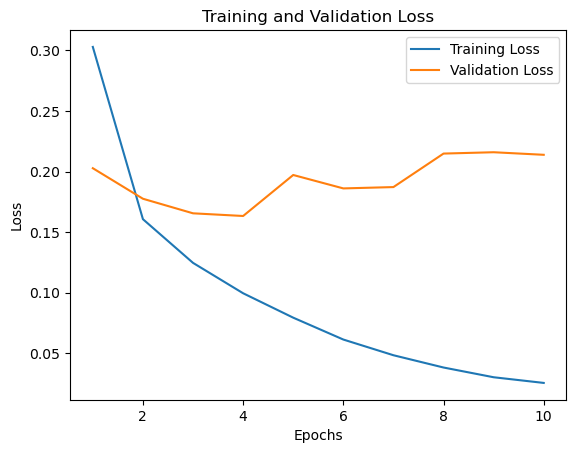

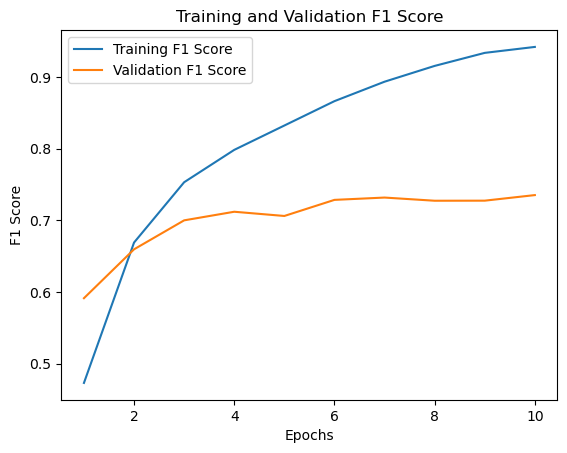

BiLSTM Model Testing using fasttext embeddings (Test F1 Score): 0.7437


In [10]:
# Hyperparameters
input_size = 300
hidden_size = 128
output_size = 27  # Number of classes (BIO tags)
learning_rate = 0.001
num_epochs = 10


print(f'\nTraining BiLSTM-CRF model with fasttext embeddings:')
model = BiLSTMCRF(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()S
train_model(model, fasttext_train_embeddings, fasttext_val_embeddings, criterion, optimizer, num_epochs)

# Calculate and print the test F1 score
test_f1_score = calculate_f1_score(model, fasttext_test_embeddings)
print(f'BiLSTM Model Testing using fasttext embeddings (Test F1 Score): {test_f1_score:.4f}')

# Save the trained model
torch.save(model.state_dict(), f'bilstm_fasttext_model_NER.pth')

# label wise F1 score 

In [25]:
from sklearn.metrics import f1_score

def calculate_f1_score_(model, test_loader, idx_B, idx_I):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(0)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 2)
            for pred, label in zip(predicted.view(-1).cpu().numpy(), labels.view(-1).cpu().numpy()):
                pred_label = idx_B if pred == idx_B or pred == idx_I else 26  
                true_label = idx_B if label == idx_B or label == idx_I else 26
                predictions.append(pred_label)
                true_labels.append(true_label)
    test_f1 = f1_score(true_labels, predictions, average='macro')
    return test_f1

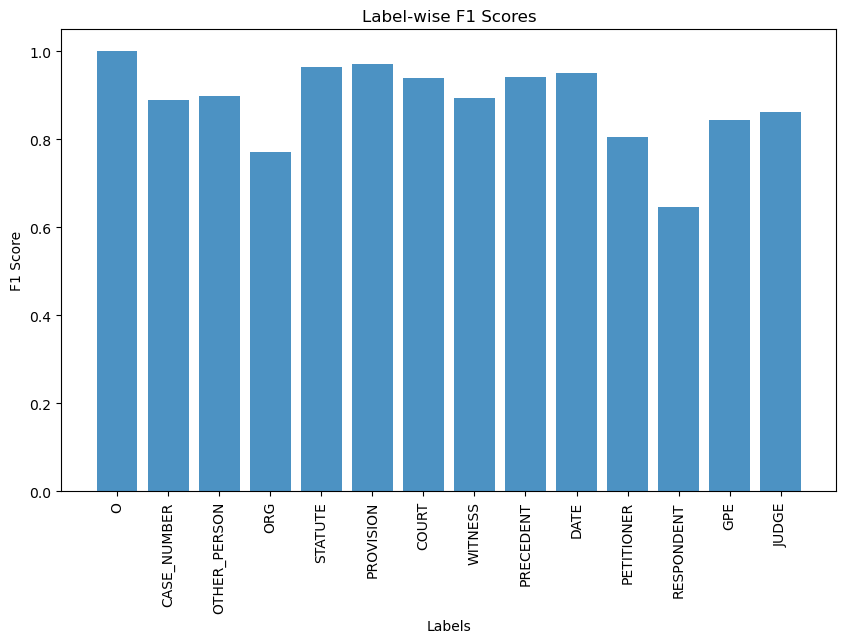

In [28]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['O', 'CASE_NUMBER', 'OTHER_PERSON', 'ORG', 'STATUTE', 'PROVISION', 'COURT', 'WITNESS', 'PRECEDENT', 'DATE', 'PETITIONER', 'RESPONDENT', 'GPE', 'JUDGE']
label_indices = [26, 20, 24, 10, 14, 16, 0, 22, 18, 8, 2, 4, 12, 6]

label_f1_scores = {}
for label, idx in zip(labels, label_indices):
    idx_B = idx
    idx_I = idx + 1
    f1 = calculate_f1_score_(model, fasttext_test_embeddings, idx_B, idx_I)
    label_f1_scores[label] = f1

plt.figure(figsize=(10, 6))
plt.bar(range(len(label_f1_scores)), list(label_f1_scores.values()), align='center', alpha=0.8)
plt.xticks(range(len(label_f1_scores)), list(label_f1_scores.keys()), rotation='vertical')
plt.ylabel('F1 Score')
plt.xlabel('Labels')
plt.title('Label-wise F1 Scores')
plt.show()


In [30]:
average_f1_score = sum(label_f1_scores.values()) / len(label_f1_scores)
print(average_f1_score)


0.883909530220785
